In [1]:
%%capture
!pip install datasets

In [2]:
from datasets import load_dataset, load_metric
from cycler import cycler
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## **Download Webis-TLDR-17**

- No train-val-test split for this dataset is provided/mentioned anywhere 
- We download Webis-TLDR-17 from Hugging Face datasets 
- the split='train' downloads the whole dataset

In [3]:
webis_tldr = load_dataset('reddit', split='train')

Found cached dataset reddit (C:/Users/Anna/.cache/huggingface/datasets/reddit/default/1.0.0/bd1bf9097540c9101f329c123d12c6c6a042f65e5f0ab7f9bbabb0a54d3c840e)


In [4]:
webis_tldr

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary'],
    num_rows: 3848330
})

In [5]:
type(webis_tldr)

datasets.arrow_dataset.Dataset

In [6]:
webis_tldr_df = webis_tldr.to_pandas() # Alternatively webis_tldr.set_format('pandas')

In [7]:
webis_tldr_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,c69al3r,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,c6a9nxd,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,c6acx4l,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,c8onqew,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,c6acxvc,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.


**Count the frequency of each subreddit in Webis-TLDR-17**

In [8]:
webis_tldr_subreddits = webis_tldr_df['subreddit'].value_counts()

In [9]:
webis_tldr_subreddits

subreddit
AskReddit              589947
relationships          352049
leagueoflegends        109307
tifu                    52219
relationship_advice     50416
                        ...  
wherecanibuythis            1
CargoCommander              1
BEARFIGHTASP                1
concertreviews              1
FrozenGames                 1
Name: count, Length: 29651, dtype: int64

Webis-TLDR-17 contains 29651 subreddits, or more precisely 29650 subreddits and also source texts with no subreddit name (29650 + empty subreddit name)

In [10]:
webis_tldr_subreddits[0:50]

subreddit
AskReddit               589947
relationships           352049
leagueoflegends         109307
tifu                     52219
relationship_advice      50416
trees                    47286
gaming                   43851
atheism                  43268
AdviceAnimals            40783
funny                    40171
politics                 36518
pics                     35098
sex                      28806
WTF                      25781
explainlikeimfive        25482
todayilearned            25004
Fitness                  22694
IAmA                     22689
worldnews                22577
DotA2                    22405
TwoXChromosomes          21562
videos                   20567
DestinyTheGame           19878
reddit.com               19020
offmychest               17175
buildapc                 14817
AskMen                   14538
personalfinance          14403
summonerschool           13806
technology               13700
wow                      13309
NoFap                    1320

In [11]:
webis_tldr_subreddits_df = pd.DataFrame({'subreddit':webis_tldr_subreddits.index, 'count':webis_tldr_subreddits.values})

In [12]:
webis_tldr_subreddits_df

,subreddit,count
0,AskReddit,589947
1,relationships,352049
2,leagueoflegends,109307
3,tifu,52219
4,relationship_advice,50416
...,...,...
29646,wherecanibuythis,1
29647,CargoCommander,1
29648,BEARFIGHTASP,1
29649,concertreviews,1


In [13]:
subreddits = webis_tldr_subreddits_df['subreddit'].tolist()
counts = webis_tldr_subreddits_df['count'].tolist()

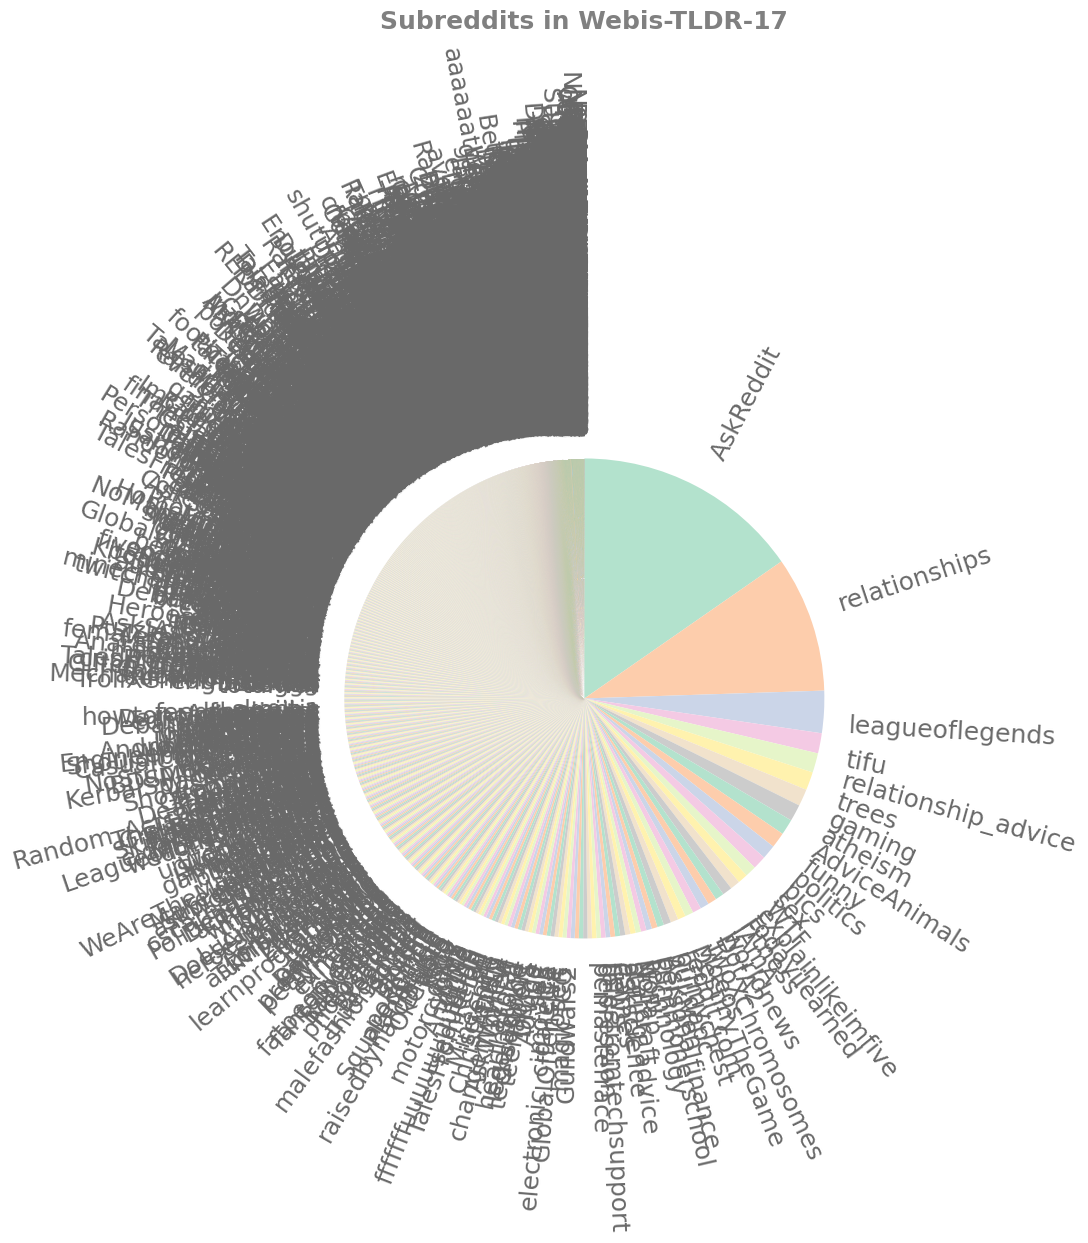

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_prop_cycle(cycler(color=plt.get_cmap('Pastel2').colors))

_, _ = ax.pie(counts,
              labels = subreddits,
              textprops={'fontsize': 18, 'color':'dimgray'},
              rotatelabels=True,
              counterclock=False,
              startangle=-270)

ax.set_title('Subreddits in Webis-TLDR-17\n\n\n\n\n\n\n\n\n\n\n\n\n', fontsize=18, color='grey', fontweight='bold')
plt.show()

Since a plot like the above is not convenient and perhaps not even as informative as it should, the following code processes a DataFrame containing subreddit data, categorizing the subreddits into two groups:
- the top 10 most popular subreddits.
- the rest of the subreddits, grouped into bins based on their count.

In [15]:
# Select the top 10 most popular subreddits
most_popular_subreddits_df = webis_tldr_subreddits_df.copy()
most_popular_subreddits_df = most_popular_subreddits_df[0:10]


# Get the rest of the subreddits (exclude the top 10 most popular subreddits )
rest_of_subreddits = webis_tldr_subreddits_df.copy()
rest_of_subreddits = rest_of_subreddits[10:]

# Bin the counts of the rest of the subreddits into predefined ranges
rest_of_subreddits['bins'] = pd.cut(x=rest_of_subreddits['count'], 
                                 bins=[0, 999, 4999, 9999, 19999, 39999],
                                 labels=['1-999',
                                        '1000-4999',
                                        '5000-9999',
                                        '10000-19999', 
                                        '20000-39999'])

# Group the rest of the subreddits by bins and sum the counts within each bin
rest_of_subreddits.groupby('bins').sum()

# Group the rest of the subreddits by bins and sum the counts within each bin
bins_df = rest_of_subreddits.groupby('bins').sum()
bins_df = bins_df.reset_index()
# Drop the 'subreddit' column as it's not needed
bins_df.drop('subreddit', axis=1, inplace=True)
bins_df.rename(columns = {'bins':'subreddit'}, inplace=True)
bins_reversed_df = bins_df[::-1]

# Concatenate the most popular subreddits DataFrame and the reversed bins DataFrame
frames = [most_popular_subreddits_df, bins_reversed_df]
result = pd.concat(frames, ignore_index=True)

# Extract the subreddit names and corresponding counts from the result DataFrame
subreddits = result['subreddit']
counts = result['count']

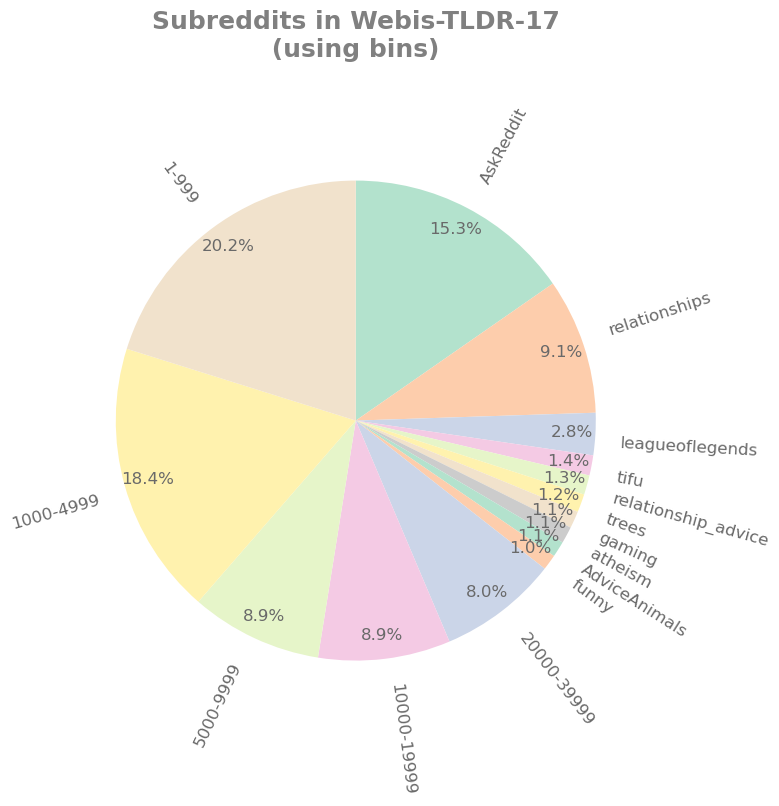

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1])

ax.set_prop_cycle(cycler(color=plt.get_cmap('Pastel2').colors))

ax.pie(counts,
       labels = subreddits,
       textprops={'fontsize': 12, 'color':'dimgray'},
       rotatelabels=True,
       counterclock=False,
       startangle=-270,
       autopct='%1.1f%%',
       pctdistance=0.9)

ax.set_title("Subreddits in Webis-TLDR-17\n (using bins) \n\n", fontsize=18, color='grey', fontweight='bold')  
plt.show()

# Select a slice of the Webis-TLDR-17; the whole dataset it is too big to load to a pandas dataframe on Colab

In [17]:
webis_tldr_shuffled = webis_tldr.shuffle(seed=42)
webis_tldr_mini = webis_tldr_shuffled.select(range(37210)) # maximum size that fit into Colab RAM

Loading cached shuffled indices for dataset at C:\Users\Anna\.cache\huggingface\datasets\reddit\default\1.0.0\bd1bf9097540c9101f329c123d12c6c6a042f65e5f0ab7f9bbabb0a54d3c840e\cache-d45e519d5f4ec953.arrow


In [18]:
webis_tldr_mini_df = webis_tldr_mini.to_pandas()

In [19]:
webis_tldr_mini_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,HgUuGiGtIaEr,Watching Alexi Laiho from Children of Bodom pl...,Watching Alexi Laiho from Children of Bodom pl...,Guitar,t5_2qi79,cfvz1jv,Watching Alexi Laiho from Children of Bodom pl...,Wanted to emulate guitar player from a band I ...
1,st_gulik,Long Story Short: I'm starting a new campaign ...,Long Story Short: I'm starting a new campaign ...,rpg,t5_2qh2s,c098n8x,Long Story Short: I'm starting a new campaign ...,Can you help me think of a new kick ass settin...
2,ErusSenex,"Commenting here for visibility, unrelated to D...","Commenting here for visibility, unrelated to D...",GameDeals,t5_2qwx3,ca7ua25,"Commenting here for visibility, unrelated to D...","Grid 2 is fun, but driving physics don't feel ..."
3,booshyschmoozy,"Currently on my 2nd read of all the books, and...","Currently on my 2nd read of all the books, and...",asoiaf,t5_2r2o9,t3_2mxaev,"Currently on my 2nd read of all the books, and...",Tywin wrote to Pycell during Robert's Rebellio...
4,[deleted],"He's now a ""consultant"" for Ambit energy. Simp...","He's now a ""consultant"" for Ambit energy. Simp...",AskReddit,t5_2qh1i,t3_hjhp8,"He's now a ""consultant"" for Ambit energy. Simp...",My dad is investing time and money into a scam...


In [20]:
webis_tldr_mini_subreddits = webis_tldr_mini_df["subreddit"].value_counts()

In [21]:
webis_tldr_mini_subreddits

subreddit
AskReddit              5746
relationships          3466
leagueoflegends        1059
tifu                    543
relationship_advice     480
                       ... 
test                      1
csfiringrange             1
gw2esports                1
dragoncon                 1
journalofboredom          1
Name: count, Length: 3755, dtype: int64

In [22]:
webis_tldr_mini_subreddits_df = pd.DataFrame({'subreddit':webis_tldr_mini_subreddits.index, 'count':webis_tldr_mini_subreddits.values})

In [23]:
subreddits = webis_tldr_mini_subreddits.index.tolist()
counts = webis_tldr_mini_subreddits.values.tolist()

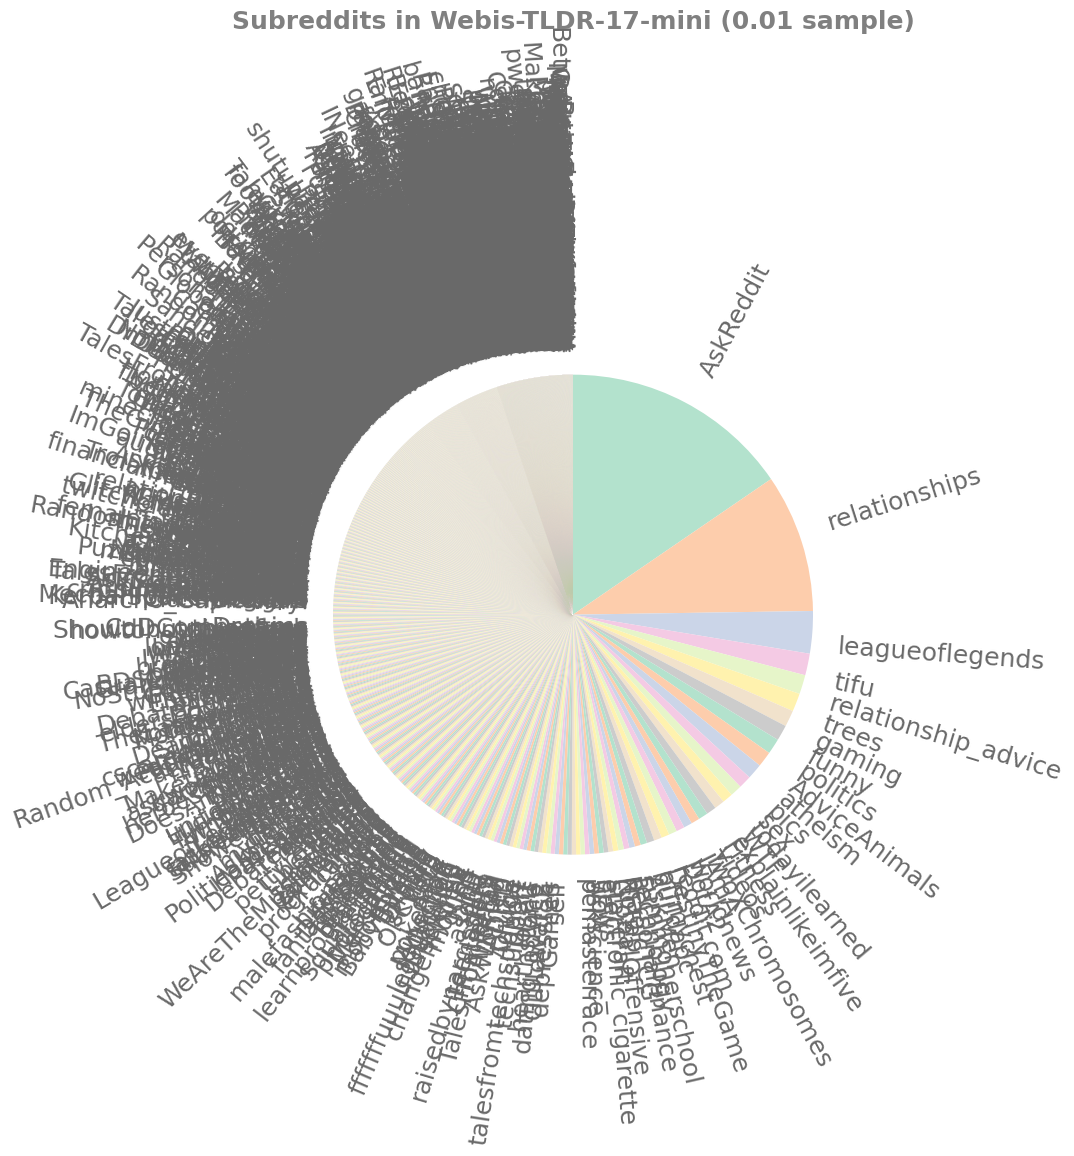

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_prop_cycle(cycler(color=plt.get_cmap('Pastel2').colors))
ax.set_facecolor('white')

_, _ = ax.pie(counts,
              labels = subreddits,
              textprops={'fontsize': 18, 'color':'dimgray'},
              rotatelabels=True,
              counterclock=False,
              startangle=-270)

ax.set_frame_on(False)

for _, spine in ax.spines.items():
    spine.set_visible(False)


ax.set_title('Subreddits in Webis-TLDR-17-mini (0.01 sample)\n\n\n\n\n\n\n\n\n\n', fontsize=18, color='grey', fontweight='bold')    
plt.show()

In [25]:
most_popular_subreddits_df = webis_tldr_mini_subreddits_df.copy()
most_popular_subreddits_df = most_popular_subreddits_df[0:10]

rest_subreddits = webis_tldr_mini_subreddits_df.copy()
rest_subreddits = rest_subreddits[10:]

rest_subreddits['bins'] = pd.cut(x=rest_subreddits['count'], 
                                 bins=[0, 9, 49, 99, 199, 399],
                                 labels=['<10',
                                        '10-49',
                                        '50-99',
                                        '100-199', 
                                        '200-399'])

# print(rest_subreddits['bins'].unique())
rest_subreddits.groupby('bins').sum()

bins_df = rest_subreddits.groupby('bins').sum()
bins_df = bins_df.reset_index()
# Drop the 'subreddit' column as it's not needed
bins_df.drop('subreddit', axis=1, inplace=True)
bins_df.rename(columns = {'bins':'subreddit'}, inplace=True)
bins_reversed_df = bins_df[::-1]

frames = [most_popular_subreddits_df, bins_reversed_df]
result = pd.concat(frames)

# Drop rows where the column value meets a certain condition
result = result.drop(result[result['count'] == 0].index)

subreddits = result['subreddit']
counts = result['count']

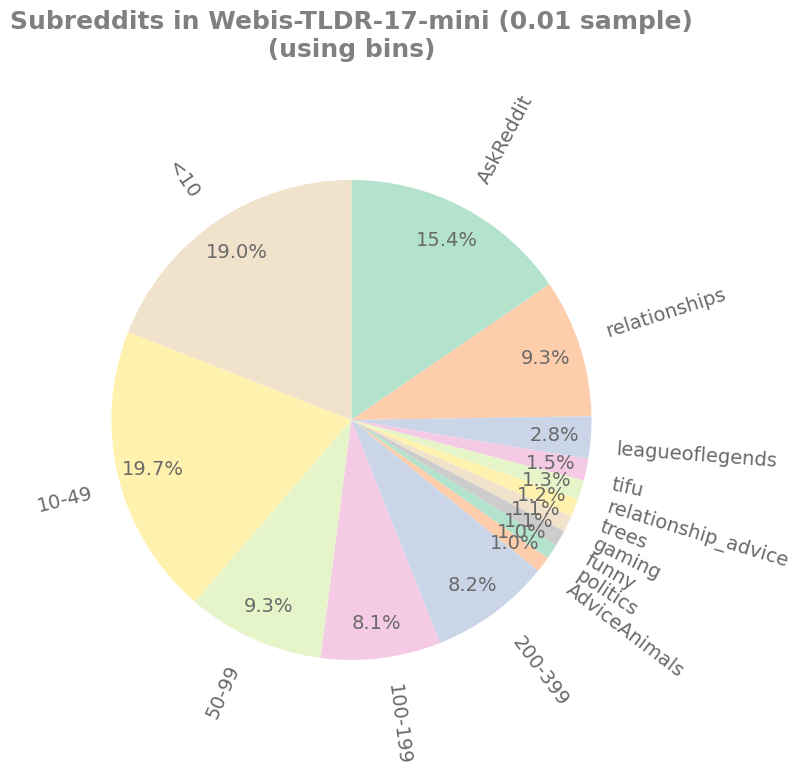

In [26]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1])

ax.set_prop_cycle(cycler(color=plt.get_cmap('Pastel2').colors))

ax.pie(counts,
       labels = subreddits,
       textprops={'fontsize': 14, 'color':'dimgray'},
       rotatelabels=True,
       counterclock=False,
       startangle=-270,
       autopct='%1.1f%%',
       pctdistance=0.85)

ax.set_title("Subreddits in Webis-TLDR-17-mini (0.01 sample)\n (using bins) \n\n", fontsize=18, color='grey', fontweight='bold')    
plt.show()

* Compute the length (number of words) of the source texts & the tldr summaries  
* Add columns 'text_len' & 'tldr_len' to the dataframe

In [27]:
webis_tldr_mini_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,HgUuGiGtIaEr,Watching Alexi Laiho from Children of Bodom pl...,Watching Alexi Laiho from Children of Bodom pl...,Guitar,t5_2qi79,cfvz1jv,Watching Alexi Laiho from Children of Bodom pl...,Wanted to emulate guitar player from a band I ...
1,st_gulik,Long Story Short: I'm starting a new campaign ...,Long Story Short: I'm starting a new campaign ...,rpg,t5_2qh2s,c098n8x,Long Story Short: I'm starting a new campaign ...,Can you help me think of a new kick ass settin...
2,ErusSenex,"Commenting here for visibility, unrelated to D...","Commenting here for visibility, unrelated to D...",GameDeals,t5_2qwx3,ca7ua25,"Commenting here for visibility, unrelated to D...","Grid 2 is fun, but driving physics don't feel ..."
3,booshyschmoozy,"Currently on my 2nd read of all the books, and...","Currently on my 2nd read of all the books, and...",asoiaf,t5_2r2o9,t3_2mxaev,"Currently on my 2nd read of all the books, and...",Tywin wrote to Pycell during Robert's Rebellio...
4,[deleted],"He's now a ""consultant"" for Ambit energy. Simp...","He's now a ""consultant"" for Ambit energy. Simp...",AskReddit,t5_2qh1i,t3_hjhp8,"He's now a ""consultant"" for Ambit energy. Simp...",My dad is investing time and money into a scam...


In [28]:
webis_tldr_mini_df['doc_len'] = [len(doc.split()) for doc in webis_tldr_mini_df['content']]
webis_tldr_mini_df['tldr_len'] = [len(tldr.split()) for tldr in webis_tldr_mini_df['summary']]

# **Documents (Source texts)**

In [29]:
print("**Source texts**")
print(f"Mean length: {round(webis_tldr_mini_df['doc_len'].mean(),2)} words")
print(f"Length std: {round(webis_tldr_mini_df['doc_len'].std(), 2)}")
print(f"Minimum number of words: {webis_tldr_mini_df['doc_len'].min()}")
print(f"Maximum number of words: {webis_tldr_mini_df['doc_len'].max()}")

**Source texts**
Mean length: 269.87 words
Length std: 273.26
Minimum number of words: 2
Maximum number of words: 6530


In [30]:
docs_len_counts = webis_tldr_mini_df['doc_len'].value_counts().sort_index(ascending=True)
docs_len_counts_df = pd.DataFrame({'doc_len': docs_len_counts.index, 'counts': docs_len_counts.values})
num_of_words = docs_len_counts_df['doc_len'].tolist()
counts = docs_len_counts_df['counts'].tolist()

docs_len_counts_ones_df = docs_len_counts_df.loc[docs_len_counts_df['counts']==1]
single_num_of_words = docs_len_counts_ones_df['doc_len'].tolist()
ones = docs_len_counts_ones_df['counts'].tolist()

In [31]:
docs_len_counts_df

,doc_len,counts
0,2,12
1,3,25
2,4,37
3,5,35
4,6,42
...,...,...
1562,3830,1
1563,4692,1
1564,5369,1
1565,5846,1


In [32]:
docs_len_counts_ones_df

,doc_len,counts
773,775,1
788,790,1
817,820,1
826,830,1
854,858,1
...,...,...
1562,3830,1
1563,4692,1
1564,5369,1
1565,5846,1


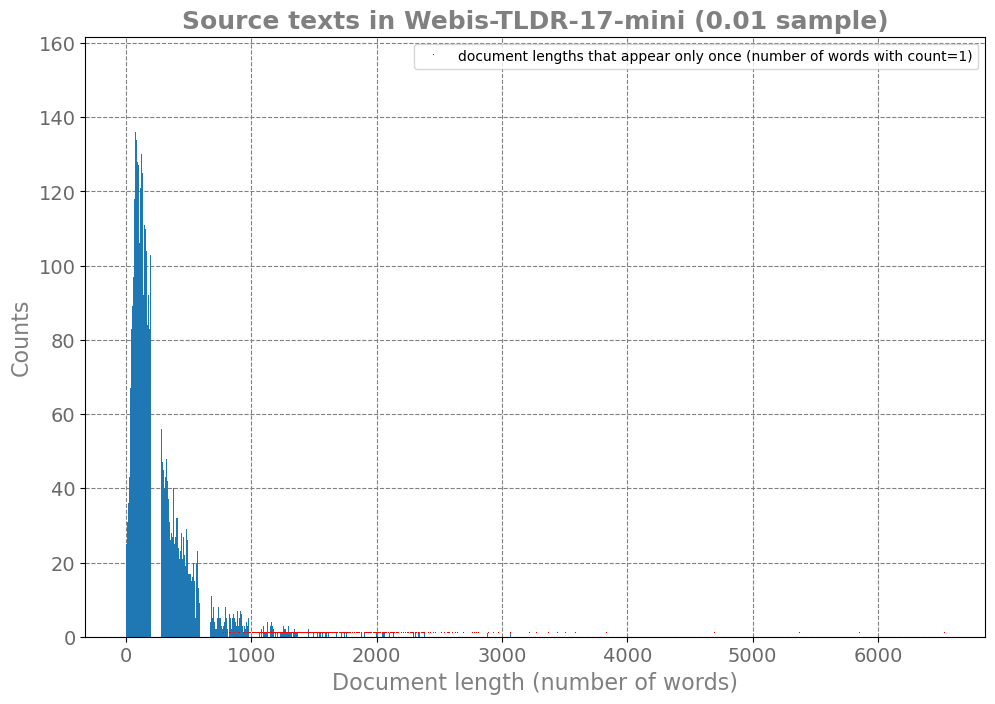

In [33]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_axes([0,0,1,1])
ax.bar(num_of_words, counts)
ax.set_xlabel('Document length (number of words)', fontsize=16, color='grey') 
ax.set_ylabel('Counts', fontsize=16, color='grey')
ax.set_title('Source texts in Webis-TLDR-17-mini (0.01 sample)', fontsize=18, color='grey', fontweight='bold')
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.plot(single_num_of_words,
         ones,
         marker=',', 
         color='r',
         label='document lengths that appear only once (number of words with count=1)',
         linestyle='None')


plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.legend(fontsize='medium')
plt.show()

# **Tldr summaries**

In [34]:
print("**Tldr summaries**")
print(f"Mean length: {round(webis_tldr_mini_df['tldr_len'].mean(),2)} words")
print(f"Length std: {round(webis_tldr_mini_df['tldr_len'].std(), 2)}")
print(f"Minimum number of words: {webis_tldr_mini_df['tldr_len'].min()}")
print(f"Maximum number of words: {webis_tldr_mini_df['tldr_len'].max()}")

**Tldr summaries**
Mean length: 26.25 words
Length std: 34.45
Minimum number of words: 1
Maximum number of words: 1469


In [35]:
tldrs_len_counts = webis_tldr_mini_df['tldr_len'].value_counts().sort_index(ascending=True)
tldrs_len_counts_df = pd.DataFrame({'num_of_words': tldrs_len_counts.index, 'counts': tldrs_len_counts.values})
num_of_words = tldrs_len_counts_df['num_of_words'].tolist()
counts = tldrs_len_counts_df['counts'].tolist()

tldrs_len_counts_ones_df = tldrs_len_counts_df.loc[tldrs_len_counts_df['counts']==1]
single_num_of_words = tldrs_len_counts_ones_df['num_of_words'].tolist()
ones = tldrs_len_counts_ones_df['counts'].tolist()

In [36]:
tldrs_len_counts_df

,num_of_words,counts
0,1,500
1,2,549
2,3,896
3,4,1040
4,5,1038
...,...,...
321,816,1
322,955,1
323,1171,1
324,1221,1


In [37]:
tldrs_len_counts_ones_df

,num_of_words,counts
166,167,1
168,169,1
180,181,1
208,210,1
213,216,1
...,...,...
321,816,1
322,955,1
323,1171,1
324,1221,1


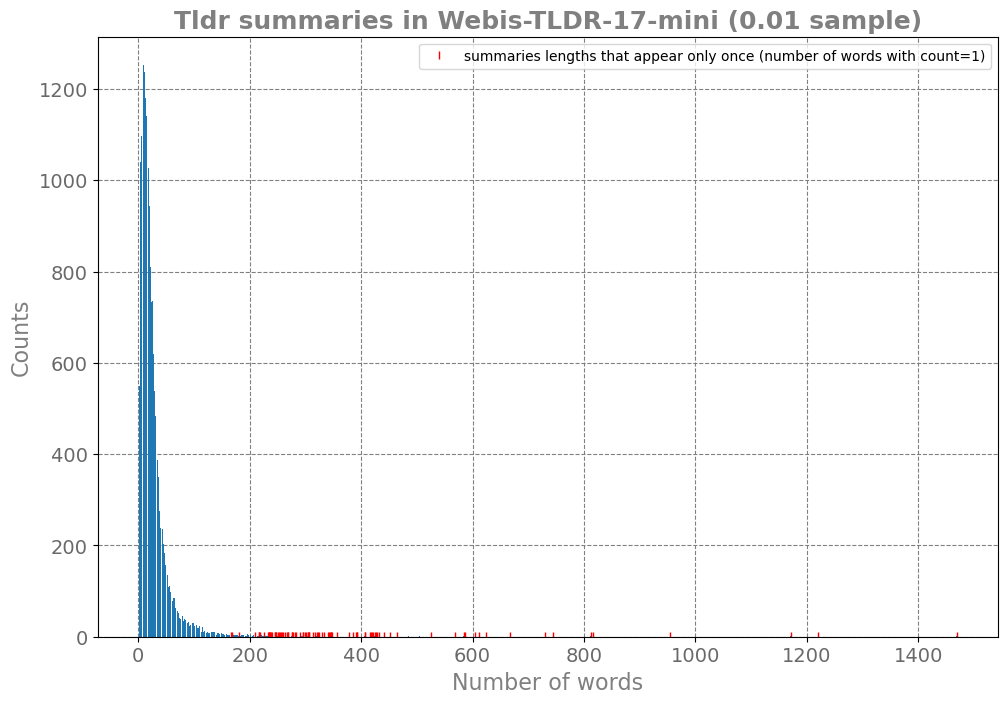

In [38]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
ax = fig.add_axes([0,0,1,1])
ax.bar(num_of_words, counts)
ax.set_xlabel('Number of words', fontsize=16, color='grey')
ax.set_ylabel('Counts', fontsize=16, color='grey')
ax.set_title('Tldr summaries in Webis-TLDR-17-mini (0.01 sample)', fontsize=18, color='grey', fontweight='bold')
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.plot(single_num_of_words,
         ones,
         marker='|', 
         color='r',
         label='summaries lengths that appear only once (number of words with count=1)',
         linestyle='None')


plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.legend(fontsize='medium')
plt.show()

In [39]:
webis_tldr_mini_df['tldr_doc_ratio'] =  webis_tldr_mini_df['tldr_len']/webis_tldr_mini_df['doc_len']

In [40]:
webis_tldr_mini_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary,doc_len,tldr_len,tldr_doc_ratio
0,HgUuGiGtIaEr,Watching Alexi Laiho from Children of Bodom pl...,Watching Alexi Laiho from Children of Bodom pl...,Guitar,t5_2qi79,cfvz1jv,Watching Alexi Laiho from Children of Bodom pl...,Wanted to emulate guitar player from a band I ...,81,13,0.160494
1,st_gulik,Long Story Short: I'm starting a new campaign ...,Long Story Short: I'm starting a new campaign ...,rpg,t5_2qh2s,c098n8x,Long Story Short: I'm starting a new campaign ...,Can you help me think of a new kick ass settin...,151,25,0.165563
2,ErusSenex,"Commenting here for visibility, unrelated to D...","Commenting here for visibility, unrelated to D...",GameDeals,t5_2qwx3,ca7ua25,"Commenting here for visibility, unrelated to D...","Grid 2 is fun, but driving physics don't feel ...",138,19,0.137681
3,booshyschmoozy,"Currently on my 2nd read of all the books, and...","Currently on my 2nd read of all the books, and...",asoiaf,t5_2r2o9,t3_2mxaev,"Currently on my 2nd read of all the books, and...",Tywin wrote to Pycell during Robert's Rebellio...,336,24,0.071429
4,[deleted],"He's now a ""consultant"" for Ambit energy. Simp...","He's now a ""consultant"" for Ambit energy. Simp...",AskReddit,t5_2qh1i,t3_hjhp8,"He's now a ""consultant"" for Ambit energy. Simp...",My dad is investing time and money into a scam...,204,87,0.426471


In [41]:
ratios = webis_tldr_mini_df['tldr_doc_ratio'].sort_values(ascending=False)

In [42]:
ratios

8312     0.996337
1751     0.993711
18982    0.992063
2965     0.992063
23854    0.991228
           ...   
23023    0.001330
18044    0.001319
12802    0.001074
9473     0.000997
6309     0.000373
Name: tldr_doc_ratio, Length: 37210, dtype: float64

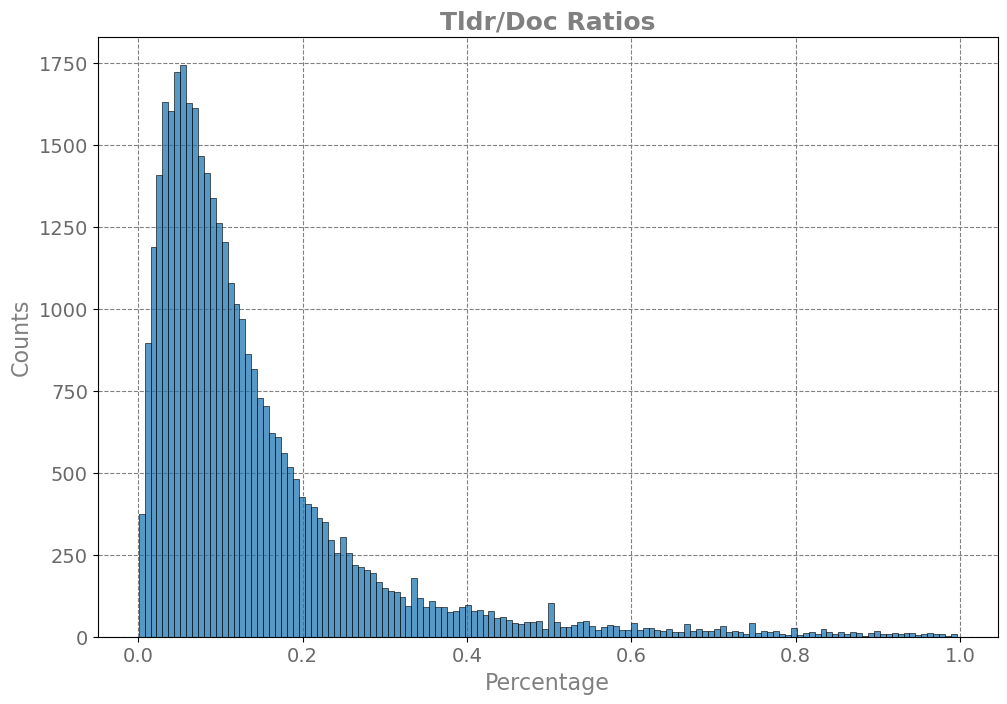

In [43]:
# Dist plot
fig = plt.figure(figsize =[9,6])
fig.patch.set_facecolor('xkcd:white')

ax = fig.add_axes([0,0,1,1])
sns.histplot(ratios)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.grid(color='gray', linestyle='dashed')

plt.title('Tldr/Doc Ratios', fontsize=18, color='grey', fontweight='bold')
plt.xlabel('Percentage', fontsize=16, color='grey')
plt.ylabel('Counts', fontsize=16, color='grey')

plt.xticks(fontsize=14, color='dimgrey')
plt.yticks(fontsize=14, color='dimgrey')
plt.show()

In [44]:
webis_tldr_mini_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary,doc_len,tldr_len,tldr_doc_ratio
0,HgUuGiGtIaEr,Watching Alexi Laiho from Children of Bodom pl...,Watching Alexi Laiho from Children of Bodom pl...,Guitar,t5_2qi79,cfvz1jv,Watching Alexi Laiho from Children of Bodom pl...,Wanted to emulate guitar player from a band I ...,81,13,0.160494
1,st_gulik,Long Story Short: I'm starting a new campaign ...,Long Story Short: I'm starting a new campaign ...,rpg,t5_2qh2s,c098n8x,Long Story Short: I'm starting a new campaign ...,Can you help me think of a new kick ass settin...,151,25,0.165563
2,ErusSenex,"Commenting here for visibility, unrelated to D...","Commenting here for visibility, unrelated to D...",GameDeals,t5_2qwx3,ca7ua25,"Commenting here for visibility, unrelated to D...","Grid 2 is fun, but driving physics don't feel ...",138,19,0.137681
3,booshyschmoozy,"Currently on my 2nd read of all the books, and...","Currently on my 2nd read of all the books, and...",asoiaf,t5_2r2o9,t3_2mxaev,"Currently on my 2nd read of all the books, and...",Tywin wrote to Pycell during Robert's Rebellio...,336,24,0.071429
4,[deleted],"He's now a ""consultant"" for Ambit energy. Simp...","He's now a ""consultant"" for Ambit energy. Simp...",AskReddit,t5_2qh1i,t3_hjhp8,"He's now a ""consultant"" for Ambit energy. Simp...",My dad is investing time and money into a scam...,204,87,0.426471


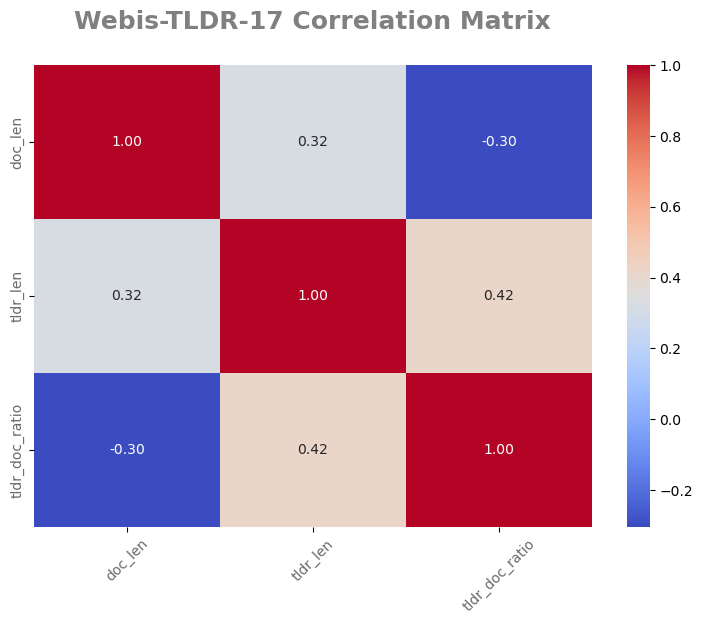

In [45]:
# Select Reddit TIFU columns with numerical values
numerical_webis_tldr_mini = webis_tldr_mini_df.select_dtypes(include="number")

# Compute correlation matrix
correlation_matrix = numerical_webis_tldr_mini.corr()

fig = plt.figure(figsize=(9, 6))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

plt.title('Webis-TLDR-17 Correlation Matrix\n', fontsize=18, color='grey', fontweight='bold')
plt.xticks(fontsize=10, color='dimgrey', rotation=45)
plt.yticks(fontsize=10, color='dimgrey')

plt.show()

In [47]:
webis_tldr_df['doc_len'] = [len(doc.split()) for doc in webis_tldr_df['content']]
webis_tldr_df['tldr_len'] = [len(tldr.split()) for tldr in webis_tldr_df['summary']]

In [48]:
webis_tldr_df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary,doc_len,tldr_len
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,c69al3r,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.,178,8
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,c6a9nxd,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.,148,4
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,c6acx4l,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...,76,73
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,c8onqew,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently...",213,19
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,c6acxvc,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.,404,7


In [65]:
webis_tldr_df_short_tldrs = webis_tldr_df.loc[webis_tldr_df['tldr_len']<=3]

In [66]:
len(webis_tldr_df_short_tldrs)

205373

In [68]:
webis_tldr_df_short_tldrs

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary,doc_len,tldr_len
417,BeastAP23,They were a top team for years and I would loo...,They were a top team for years and I would loo...,nba,t5_2qo4s,c7aqyzv,They were a top team for years and I would loo...,LEAVE BRITTANY ALONE!,128,3
425,Lobin,Fuck yeah! I would also like to state that the...,Fuck yeah! I would also like to state that the...,AskReddit,t5_2qh1i,c7bck25,Fuck yeah! I would also like to state that the...,Puddiiiinnnnng!,251,1
429,BlueTact,I don't really see a problem. It is just a sur...,I don't really see a problem. It is just a sur...,leagueoflegends,t5_2rfxx,c7bhiz4,I don't really see a problem. It is just a sur...,Downvote me plz,27,3
439,PurpleAmity,Summer of 2011. Last day of high school senior...,Summer of 2011. Last day of high school senior...,AskReddit,t5_2qh1i,c7c23lt,Summer of 2011. Last day of high school senior...,Minnesota.,171,1
482,RedditBlaze,"He seems new, lots of little mistakes, which a...","He seems new, lots of little mistakes, which a...",ftlgame,t5_2tnu1,c7gs3eu,"He seems new, lots of little mistakes, which a...",Roguelikes,137,1
489,giggity_giggity,So here's the deal. I apparently love green. ...,So here's the deal. I apparently love green. ...,Warhammer,t5_2qqd4,c7gly3n,So here's the deal. I apparently love green. ...,They're awesome.,40,2
492,excursionmoney,Straight man: I came from a very conservative ...,Straight man: I came from a very conservative ...,AskMen,t5_2s30g,c7gz41h,Straight man: I came from a very conservative ...,One.,50,1
529,cavid_david,40 Minutes til kickoff and I'm freaking out.\n...,40 Minutes til kickoff and I'm freaking out. \...,fantasyfootball,t5_2qlqq,c7ksyrp,40 Minutes til kickoff and I'm freaking out. \...,HELP,172,1
550,ICEFARMER,Marrying the right girl helps. Once you do tha...,Marrying the right girl helps. Once you do tha...,AskMen,t5_2s30g,c7lvrze,Marrying the right girl helps. Once you do tha...,too general already.,466,3
577,poppyseedtoast,I have been having a similar glitch in iTunes ...,I have been having a similar glitch in iTunes ...,iphone,t5_2qh2b,c7o8bdl,I have been having a similar glitch in iTunes ...,iTunes can glitch.,64,3


In [70]:
webis_tldr_df_short_tldrs.to_csv("webis_tldr_df_short_tldrs.csv", sep=";")